In [ ]:
pip install torch torchvision segment-anything shapely scikit-learn matplotlib opencv-python

In [ ]:
# librairies
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision import transforms
import torch.optim as optim
from PIL import Image
import numpy as np
import torch
import urllib
import numpy as np
from PIL import Image
import cv2
import urllib.request
from segment_anything import sam_model_registry, SamPredictor
from sklearn.linear_model import LogisticRegression
from itertools import combinations
import random
import matplotlib.pyplot as plt
import sys
sys.path.append("..")

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from torchvision.models.feature_extraction import create_feature_extractor

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ajustements colab
with torch.no_grad():
  torch.cuda.empty_cache()

using_colab = True
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

# **Exemple PIE implémentation sur 1 image**

Voici une première version du PIE, testée sur une seule image.

Actuellement, l’EAC détecte principalement les oreilles du chien ainsi qu’une partie de la gamelle, qui semblent être les concepts les plus importants. Mais, je pense que ce résultat peut être nettement amélioré. Par manque de ressources, j’ai pas pu tester autant de coalitions que dans l’article original (1 000 contre 50 000), ce qui limite la qualité des explications générées.

Pour reproduire la suite du papier, il faut retrouver les résultats de faithfulness, understability et ablation study.
Pour ceci, il faudrait :
- Obtenir de meilleurs résultats explicatifs sur une image individuelle.

- Implémenter un code d’évaluation de l’AUC via les méthodes d’insertion et de suppression (insertion/deletion scheme).

- Évaluer le modèle sur un ensemble plus large d’images provenant d’ImageNet et COCO.

- Mesurer la compréhensibilité des masques générés auprès de 6 annotateurs humains.

- Noter et analyser le temps de traitement pour chaque étape.

**Phase 1 : Concept Discovery**

Etape 1-2 : Charger l'image et la segmenter avec SAM

In [ ]:
def load_sample() :
  """ Load images sample """
  bus = cv2.imread('images/bus.png')
  bus = cv2.cvtColor(bus, cv2.COLOR_BGR2RGB)

  train = cv2.imread('images/train.png')
  train = cv2.cvtColor(train, cv2.COLOR_BGR2RGB)

  kitesurf = cv2.imread('images/kitesurf.png')
  kitesurf = cv2.cvtColor(kitesurf, cv2.COLOR_BGR2RGB)

  zebra = cv2.imread('images/zebra.png')
  zebra = cv2.cvtColor(zebra, cv2.COLOR_BGR2RGB)

  images = [bus, train, kitesurf, zebra]
  return images


In [ ]:
# === Segmentation with SAM ===

def load_SAM_maskGen(sam_checkpoint : str = "sam_vit_h_4b8939.pth", backbone : str = "vit_h"):
  """ load SAM model
  args :
    sam_checkpoint : (str) (default = sam_vit_h_4b8939.pth) : backbone checkpoints
    backbone : (str) (default = "vit_h") : backbone used
  return :
    mask_generator
  """
  sam = sam_model_registry[backbone](checkpoint=sam_checkpoint)
  sam.to(device=device)

  mask_generator = SamAutomaticMaskGenerator(sam)
  return mask_generator

def generate_masks( images : list, mask_generator:str = None)->list:
  """ Generate SAM masks
  args :
    images : (list) list of images to infer on
    maskk_generator : SAM mask generator if None -> SAM with vit_h backbone will be used
  return :
    list of masks of size images size
  """
  if not mask_generator :
    mask_generator = load_SAM_maskGen()
  masks = []
  for image in images:
    masks.append(mask_generator.generate(image))

  return masks


# Helper to verify anotations
def show_anns(anns)->None:
  """ Visualise annotations on top of images  """
  if len(anns) == 0:
      return None
  sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
  ax = plt.gca()
  ax.set_autoscale_on(False)

  img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
  img[:,:,3] = 0
  for ann in sorted_anns:
      m = ann['segmentation']
      color_mask = np.concatenate([np.random.random(3), [0.35]])
      img[m] = color_mask
  ax.imshow(img)


def visualise_im_annot(images, masks):
  """ Visualise anotaitons on top of the images """"
  for image, mask in zip(images, masks):
    plt.figure(figsize=(20,20))
    plt.imshow(image)
    show_anns(mask)
    plt.axis('off')
    plt.show()

In [ ]:
images = load_sample()
masks = generate_masks(images)

# let's see segmented concepts
for i, mask_list in enumerate(masks):
    print(f"Image {i} → {len(mask_list)} concepts")

# let's plot the predictions of SAM on top of the images
visualise_im_annot

Image 0 → 72 concepts
Image 1 → 100 concepts
Image 2 → 31 concepts
Image 3 → 33 concepts


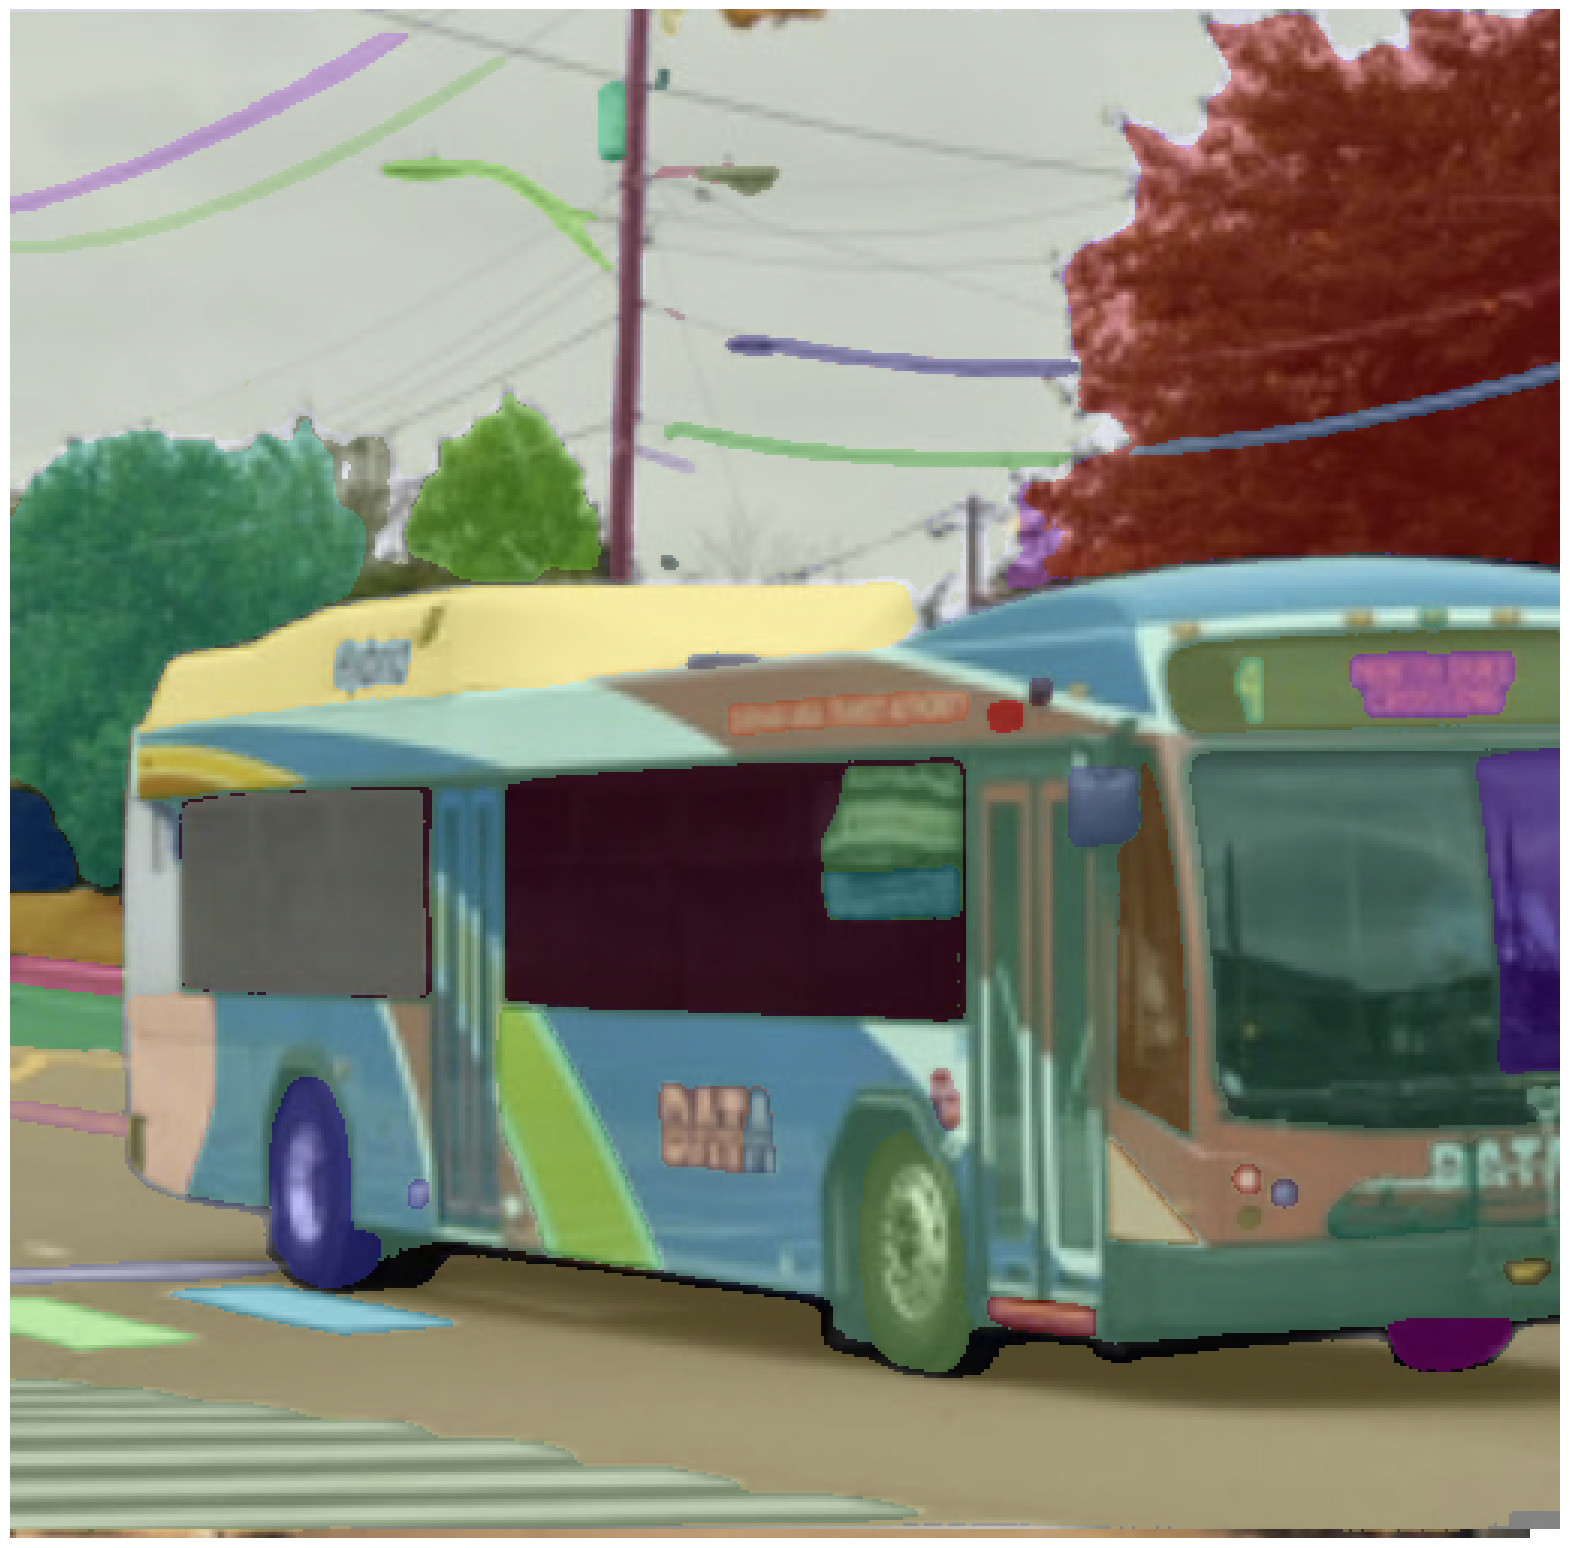

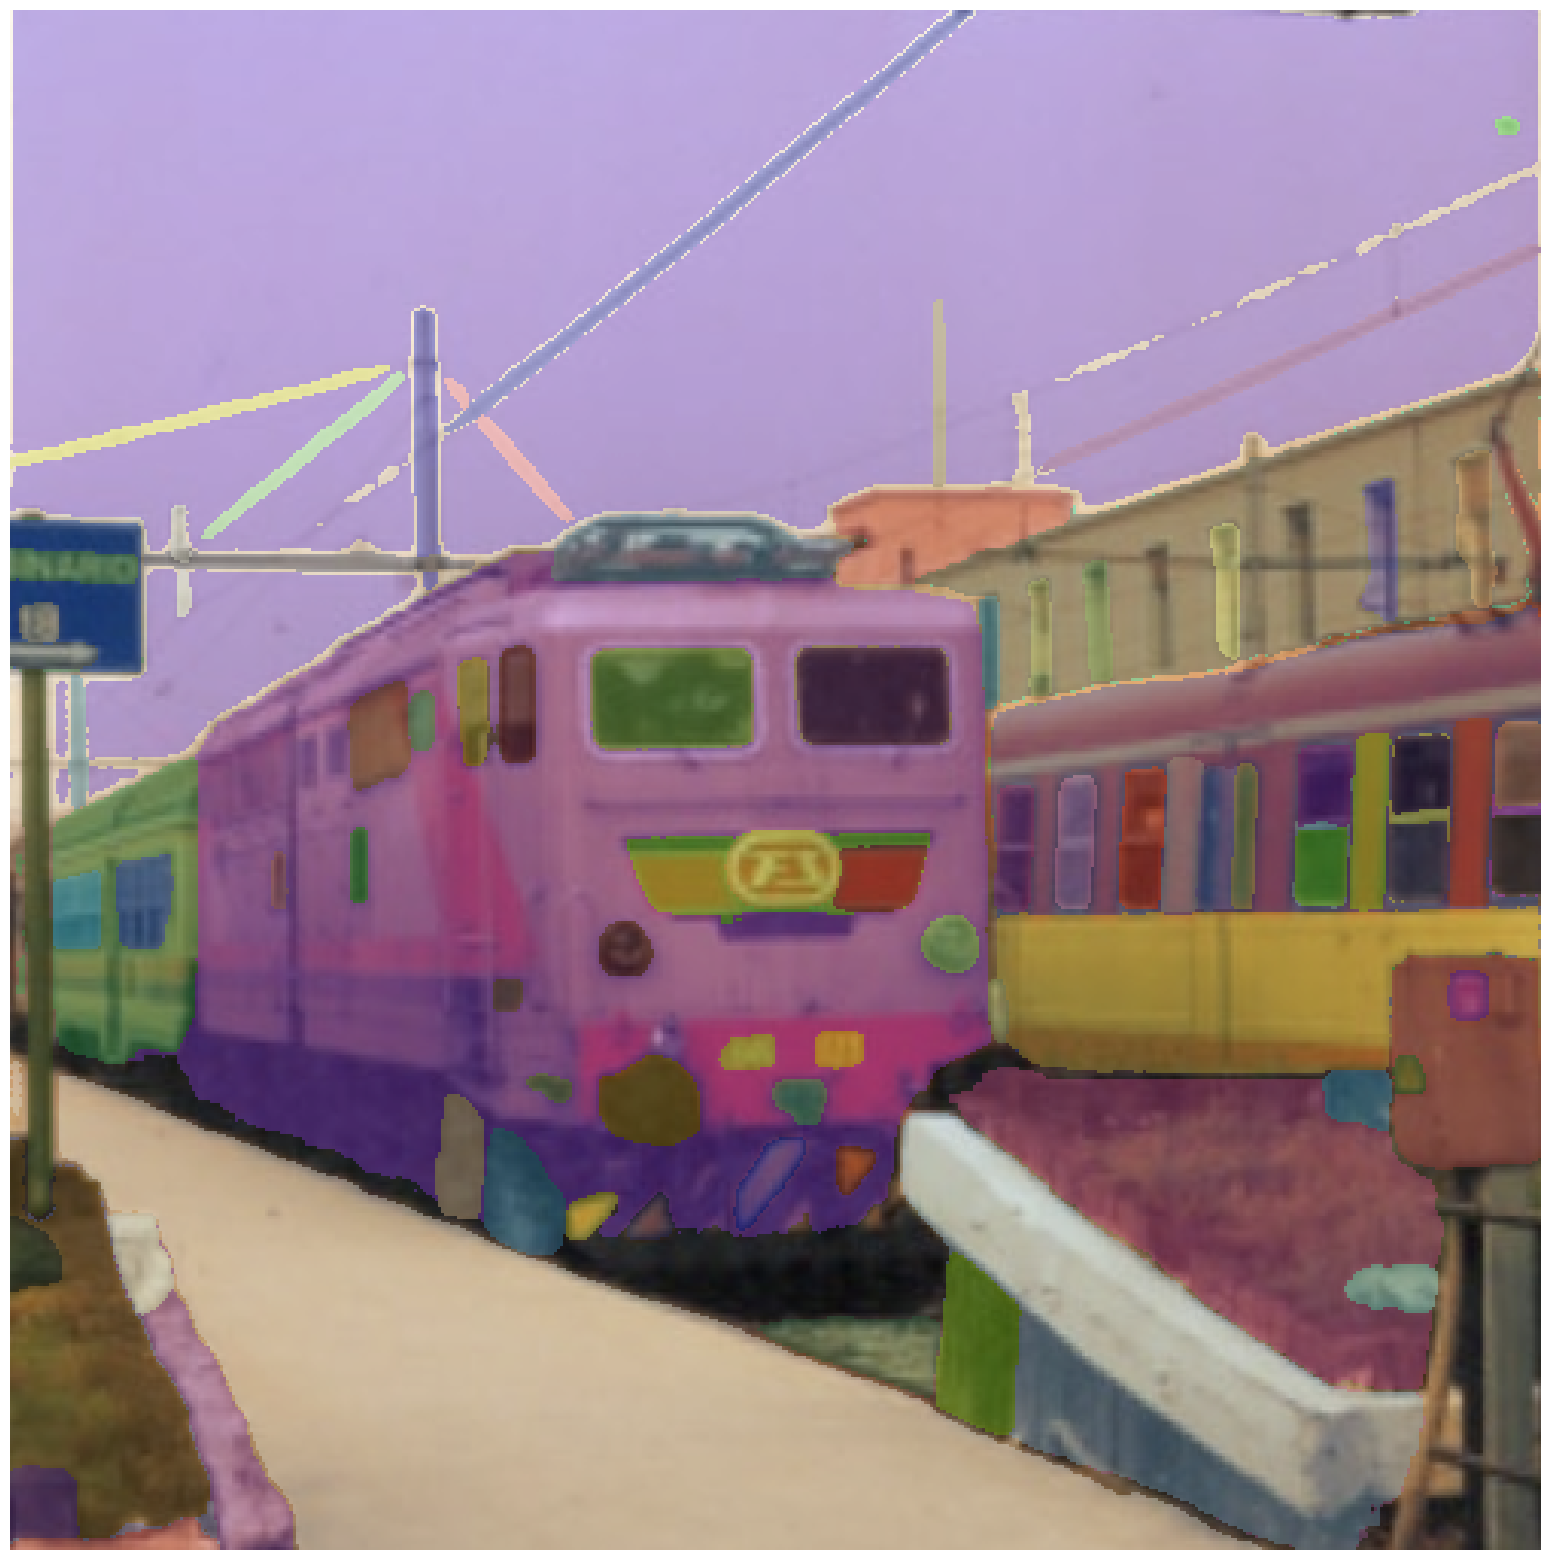

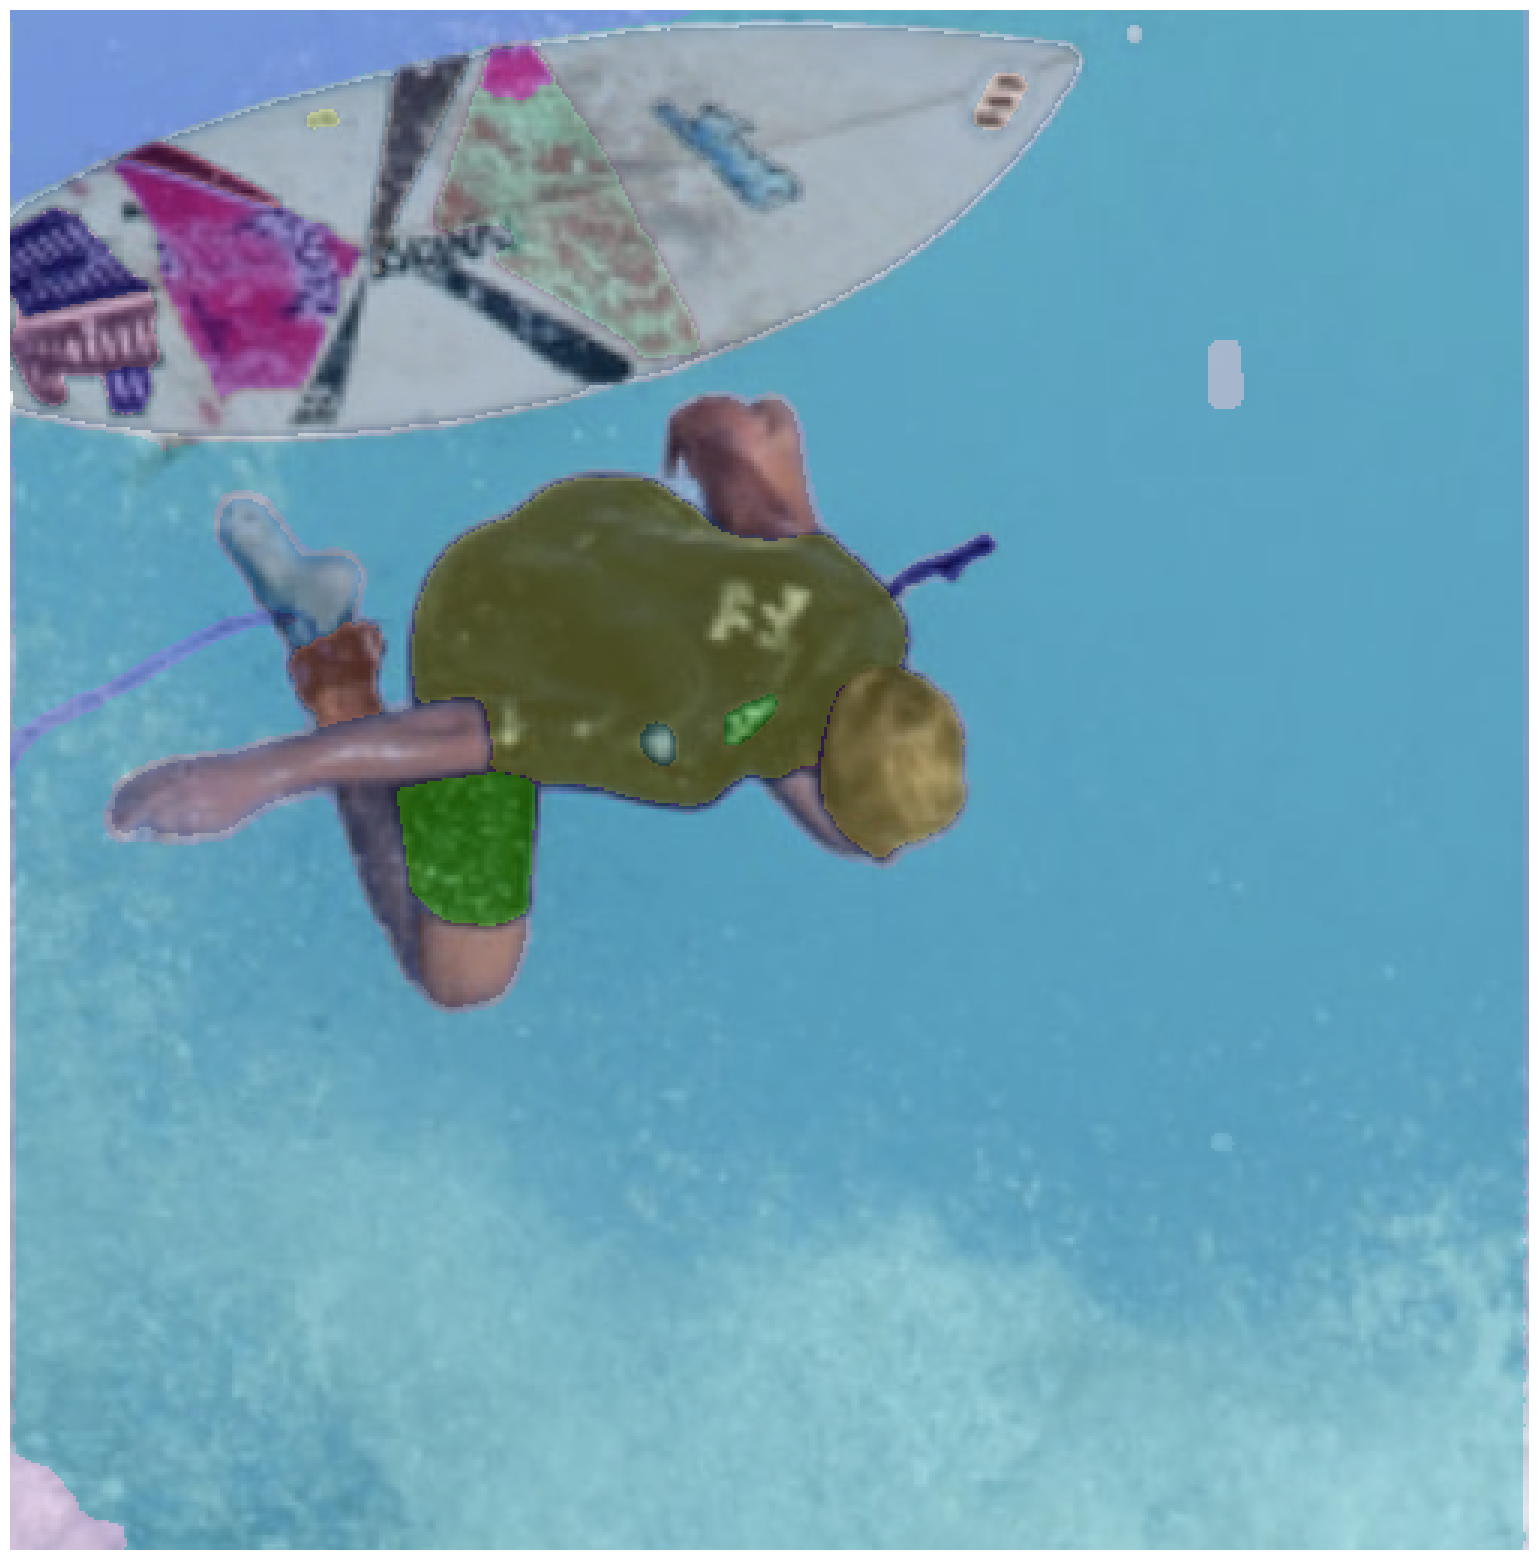

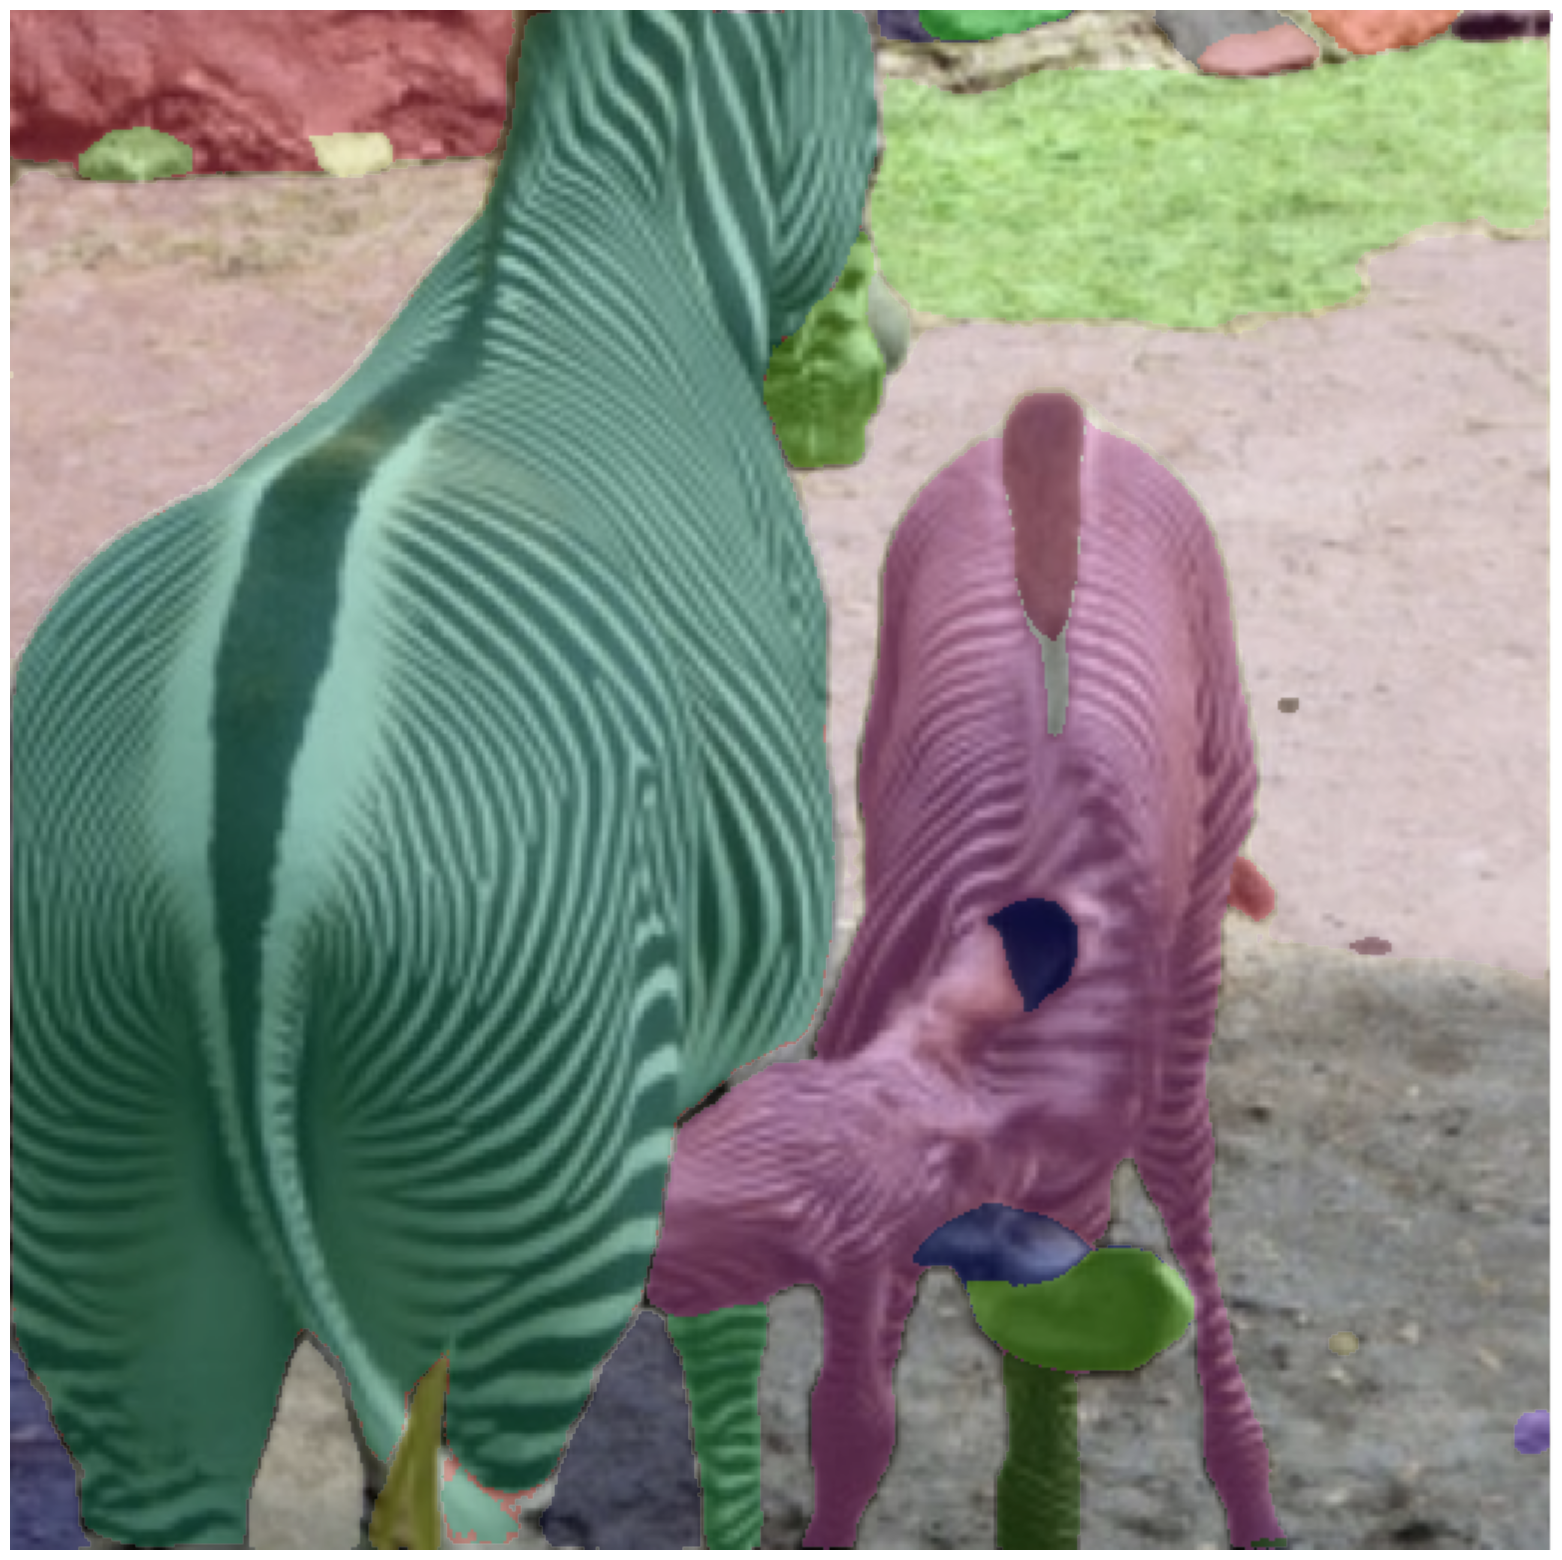

**Phase 2 : PIE**

Etape 3 : Charger modèle target : Resnet-50 pré-entrainé sur ImageNet

In [ ]:
target_model = models.resnet50(weights='IMAGENET1K_V2')
target_model.eval()
target_model = target_model.to(device)
fc_layer = target_model.fc
#feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])  # sans FC

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 215MB/s]


Tester prédiction du Resnet-50

In [ ]:
# ImageNet Normalisation (mean and std for RGB channels)
normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
)

In [ ]:

def get_predicted_classes(images_np, model, device=device, target_size=(224, 224)):
    """
    Predicts classes for a list of numpy images (HWC), resized to target_size and
    Displays the predicted class names
    Returns :
     list of predicted indices.
    """
    # Load ImageNet class names (if not already cached)
    imagenet_classes_path = "imagenet_classes.txt"
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        imagenet_classes_path
    )
    with open(imagenet_classes_path) as f:
        class_names = [line.strip() for line in f.readlines()]

    preprocess = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(target_size),
        transforms.ToTensor(),  # convert to [0,1] and [C,H,W]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    tensors = []
    for i, img in enumerate(images_np):
        if isinstance(img, np.ndarray):
            if img.dtype != np.uint8:
                img = (img * 255).astype(np.uint8)  # Ensure correct format
            img_tensor = preprocess(img)
            tensors.append(img_tensor)
        else:
            raise ValueError("Chaque image doit être un tableau numpy (H,W,C)")

    batch = torch.stack(tensors).to(device)

    with torch.no_grad():
        logits = model(batch)
        predicted_indices = torch.argmax(logits, dim=1)

    # Print names
    for i, idx in enumerate(predicted_indices):
        print(f"Image {i} → classe prédite : {idx.item()} → {class_names[idx]}")

    return predicted_indices


In [ ]:
# images_np = [img1, img2, img3, ...] (liste of numpy array HWC)
predicted_indices = get_predicted_classes(images_np=images, model=target_model)
print("List of predicted classes : ", predicted_indices.tolist())

Image 0 → classe prédite : 874 → trolleybus
Image 1 → classe prédite : 547 → electric locomotive
Image 2 → classe prédite : 701 → parachute
Image 3 → classe prédite : 340 → zebra
Liste des classes prédites :  [874, 547, 701, 340]


On remarque sur le Resnet ne prédit pas correctement l'image 2 et 3 et prédit passenger car et parachute pour des images de bus et kitesurf.

Etape 3 : Mettre en place le Surrogate modèle

Dans le papier précise que c'est 1 surrogate pour chcune des images.

In [ ]:

class SurrogateModel(torch.nn.Module):
    def __init__(self, fc_layer, num_concepts, feature_dim=2048, lr=0.008):
        super().__init__()
        self.h = torch.nn.Sequential(
            torch.nn.Linear(num_concepts, feature_dim)
        )
        self.fc = fc_layer  # shared with ResNet

        # Freeze parameters
        for param in self.fc.parameters():
          param.requires_grad = False
        self.loss = torch.nn.BCELoss()

        self.optimizer = optim.SGD(self.h.parameters(), lr=lr, momentum=0.9)

    def forward(self, b_onehot):
        features = self.h(b_onehot)
        return self.fc(features)

surrogates = []
for mask in masks:
    num_concepts = len(mask)
    surrogates.append(SurrogateModel(fc_layer, num_concepts).to("cuda"))

In [ ]:
for surrogate in surrogates:
  print(surrogate)

SurrogateModel(
  (h): Sequential(
    (0): Linear(in_features=72, out_features=2048, bias=True)
  )
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
  (loss): BCELoss()
)
SurrogateModel(
  (h): Sequential(
    (0): Linear(in_features=100, out_features=2048, bias=True)
  )
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
  (loss): BCELoss()
)
SurrogateModel(
  (h): Sequential(
    (0): Linear(in_features=31, out_features=2048, bias=True)
  )
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
  (loss): BCELoss()
)
SurrogateModel(
  (h): Sequential(
    (0): Linear(in_features=33, out_features=2048, bias=True)
  )
  (fc): Linear(in_features=2048, out_features=1000, bias=True)
  (loss): BCELoss()
)


Etape 5 : Créer le dataset d'entrainement du surrogate model = (image dont  certains concepts masqués, prédiction label du target model avec cette image masquée)

In [ ]:
import torchvision.transforms as transforms

# === Create training coalitions ===
def mask_image_from_concepts(concepts : list, concept_mask: np.ndarray, image: np.ndarray):
    """
    Masks the image, keeping only the concepts enabled in concept_mask.
    Masking is done by multiplication, not direct zero replacement.

    Args:
        concepts (list of np.array): List of boolean masks (H x W) for each concpet.
        concept_mask (np.array): Binary concept selection vector (size = number of concepts).
        image (np.array): Image RGB  (H x W x 3), dtype uint8.

    Returns:
        masked_img_tensor (torch.Tensor): Masked, normalized image, shape [1, 3, H, W].
    """

    # Initialise combined mask float 2D (H x W) to 0
    mask_combined = np.zeros(image.shape[:2], dtype=float)

    for i, mask in enumerate(concepts):
        if concept_mask[i]:
            # Add region of the concept (binary mask converted to float)
            mask_combined += mask.astype(float)

    # Cip to not exceed 1 (in case of overlapp)
    mask_combined = np.clip(mask_combined, 0, 1)

    # Extend mask_combined across all 3 channels(H x W -> H x W x 3)
    mask_combined_3ch = np.repeat(mask_combined[:, :, np.newaxis], 3, axis=2)

    # Multiply pixel-wise (float multiplication)
    masked_img = image.astype(float) * mask_combined_3ch

    # Format correction to uint8
    masked_img = masked_img.astype(np.uint8)

    # Convert to a tensor, permutate (H, W, C) -> (C, H, W) and normaliser
    masked_img_tensor = torch.from_numpy(masked_img).permute(2, 0, 1).float() / 255.
    masked_img_tensor = normalize(masked_img_tensor)
    masked_img_tensor = masked_img_tensor.unsqueeze(0)  # batch dimension

    return masked_img_tensor


In [ ]:
datasets = {}  # to store dataset per image
num_samples = 2500

for img_idx, (image, mask, predicted_index) in enumerate(zip(images, masks, predicted_indices)):
    samples = []
    labels = []

    concepts = [mask["segmentation"] for mask in masks[img_idx]]  # if masks is a list of lists (per image)
    num_concepts = len(mask)

    for _ in range(num_samples):
        mask_bin = np.random.randint(0, 2, size=(num_concepts,))
        x_masked = mask_image_from_concepts(concepts, mask_bin, image)

        with torch.no_grad():
            out = target_model(x_masked.to("cuda"))
            probs = torch.nn.functional.softmax(out, dim=1)
            prob_target = probs[:, predicted_index]
            labels.append(prob_target.item())

        samples.append(torch.FloatTensor(mask_bin))

    samples_tensor = torch.stack(samples).to("cuda")
    labels_tensor = torch.tensor(labels).float().to("cuda")

    datasets[f"image_{img_idx}"] = (samples_tensor, labels_tensor)

In [ ]:
print(f"Nombre d’images dans datasets: {len(datasets)}")
for key, (samples_t, labels_t) in datasets.items():
    print(f"{key}: samples {samples_t.shape}, labels {labels_t.shape}")
    print(f"Exemple samples[0]: {samples_t[0]}")
    print(f"Shape samples: {samples_t.shape}")
    print(f"Exemple labels[0]: {labels_t[0]}")
    print(f"Shape labels: {labels_t.shape}")
    break

Nombre d’images dans datasets: 4
image_0: samples torch.Size([2500, 72]), labels torch.Size([2500])
Exemple samples[0]: tensor([1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0.,
        0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1.],
       device='cuda:0')
Shape samples: torch.Size([2500, 72])
Exemple labels[0]: 0.01359010860323906
Shape labels: torch.Size([2500])


Etape 6 : Train surrogate model with the dataset

In [ ]:
num_epochs = 200

for img_idx, surrogate in enumerate(surrogates):
    print(f"\n=== Entraînement surrogate pour image {img_idx} ===")

    samples_tensor, labels_tensor = datasets[f"image_{img_idx}"]

    for epoch in range(num_epochs):
        surrogate.train()

        # Forward pass : predict probability of target class
        pred = torch.nn.functional.softmax(surrogate(samples_tensor), dim=1)[:, predicted_indices[img_idx]]

        # Compute BCE Loss between prediction and ground truth
        loss = surrogate.loss(pred, labels_tensor)

        # Backpropagation
        surrogate.optimizer.zero_grad()
        loss.backward()
        surrogate.optimizer.step()

        if epoch % 20 == 0 or epoch == num_epochs - 1:
            print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f}")



=== Entraînement surrogate pour image 0 ===
Epoch 000 | Loss: 0.1065
Epoch 020 | Loss: 0.0967
Epoch 040 | Loss: 0.0850
Epoch 060 | Loss: 0.0802
Epoch 080 | Loss: 0.0798
Epoch 100 | Loss: 0.0796
Epoch 120 | Loss: 0.0795
Epoch 140 | Loss: 0.0794
Epoch 160 | Loss: 0.0793
Epoch 180 | Loss: 0.0791
Epoch 199 | Loss: 0.0790

=== Entraînement surrogate pour image 1 ===
Epoch 000 | Loss: 0.0539
Epoch 020 | Loss: 0.0513
Epoch 040 | Loss: 0.0484
Epoch 060 | Loss: 0.0468
Epoch 080 | Loss: 0.0463
Epoch 100 | Loss: 0.0462
Epoch 120 | Loss: 0.0462
Epoch 140 | Loss: 0.0461
Epoch 160 | Loss: 0.0461
Epoch 180 | Loss: 0.0461
Epoch 199 | Loss: 0.0461

=== Entraînement surrogate pour image 2 ===
Epoch 000 | Loss: 0.0270
Epoch 020 | Loss: 0.0269
Epoch 040 | Loss: 0.0267
Epoch 060 | Loss: 0.0265
Epoch 080 | Loss: 0.0263
Epoch 100 | Loss: 0.0261
Epoch 120 | Loss: 0.0260
Epoch 140 | Loss: 0.0259
Epoch 160 | Loss: 0.0258
Epoch 180 | Loss: 0.0258
Epoch 199 | Loss: 0.0257

=== Entraînement surrogate pour image 3

**Phase 3 : Concept based Explanation**

On utilise le PIE à la place du target modèl pour estimer les shapley values

Pour chaque concept calcule sa contribution : Monte Carlo sampling de coalitions

DANS PAPIER K = 50 000. Consomme trop de ressources, j'arrive pas à faire tourner sur GPU.

In [ ]:
K = 10000
all_shapley_values = []

for img_idx, surrogate in enumerate(surrogates):
    print(f"\n=== Approximation Shapley pour image {img_idx} ===")
    num_concepts = surrogate.h[0].in_features  #number of concepts = input size
    shapley_values = torch.zeros(num_concepts).to("cuda")

    for i in range(num_concepts):
        print(f"=== Concept numéro {i} ===")
        for _ in range(K):
            S = torch.randint(0, 2, (num_concepts,), dtype=torch.float32).to("cuda")
            S[i] = 0
            S_with_ci = S.clone()
            S_with_ci[i] = 1

            pred_with_ci = surrogate(S_with_ci.unsqueeze(0))  # u(S ∪ {i})
            pred_without_ci = surrogate(S.unsqueeze(0))       # u(S)

            # Contribution to the probabiilty of the target class
            contrib = pred_with_ci[0][predicted_indices[img_idx]] - pred_without_ci[0][predicted_indices[img_idx]]
            shapley_values[i] += contrib

        shapley_values[i] /= K

    all_shapley_values.append(shapley_values)


=== Approximation Shapley pour image 0 ===
=== Concept numéro 0 ===
=== Concept numéro 1 ===
=== Concept numéro 2 ===
=== Concept numéro 3 ===
=== Concept numéro 4 ===
=== Concept numéro 5 ===
=== Concept numéro 6 ===
=== Concept numéro 7 ===
=== Concept numéro 8 ===
=== Concept numéro 9 ===
=== Concept numéro 10 ===
=== Concept numéro 11 ===
=== Concept numéro 12 ===
=== Concept numéro 13 ===
=== Concept numéro 14 ===
=== Concept numéro 15 ===
=== Concept numéro 16 ===
=== Concept numéro 17 ===
=== Concept numéro 18 ===
=== Concept numéro 19 ===
=== Concept numéro 20 ===
=== Concept numéro 21 ===
=== Concept numéro 22 ===
=== Concept numéro 23 ===
=== Concept numéro 24 ===
=== Concept numéro 25 ===
=== Concept numéro 26 ===
=== Concept numéro 27 ===
=== Concept numéro 28 ===
=== Concept numéro 29 ===
=== Concept numéro 30 ===
=== Concept numéro 31 ===
=== Concept numéro 32 ===
=== Concept numéro 33 ===
=== Concept numéro 34 ===
=== Concept numéro 35 ===
=== Concept numéro 36 ===
=== 

In [ ]:
all_shapley_values[0]

tensor([ 0.1413,  0.2287, -0.0922,  0.1562,  0.1895,  0.0826,  0.1847, -0.0257,
         0.1825,  0.0889,  0.1186,  0.0827,  0.0032,  0.1856, -0.0061,  0.2042,
         0.1984,  0.1799,  0.1928, -0.1843, -0.0867,  0.0500,  0.3697,  0.1909,
         0.0513,  0.0061,  0.0094, -0.0034,  0.0359, -0.0953,  0.1027, -0.0478,
         0.0974,  0.1108, -0.0782, -0.1119,  0.0851,  0.2571,  0.1573, -0.0126,
         0.0807,  0.0843,  0.0363, -0.0867, -0.1195,  0.1308, -0.1075,  0.0145,
         0.1182,  0.1317,  0.1069,  0.0245,  0.1346, -0.0317,  0.1813,  0.1625,
         0.3713, -0.0231,  0.2209,  0.0699,  0.1425,  0.0283, -0.0247,  0.1784,
         0.0664,  0.0470,  0.1307,  0.0438, -0.1983, -0.0409,  0.1457,  0.0795],
       device='cuda:0', grad_fn=<CopySlices>)

Comme dans le papier, nous générons huit explications :

[Image 0] Top-8 concepts : [56, 22, 37, 1, 58, 15, 16, 18]


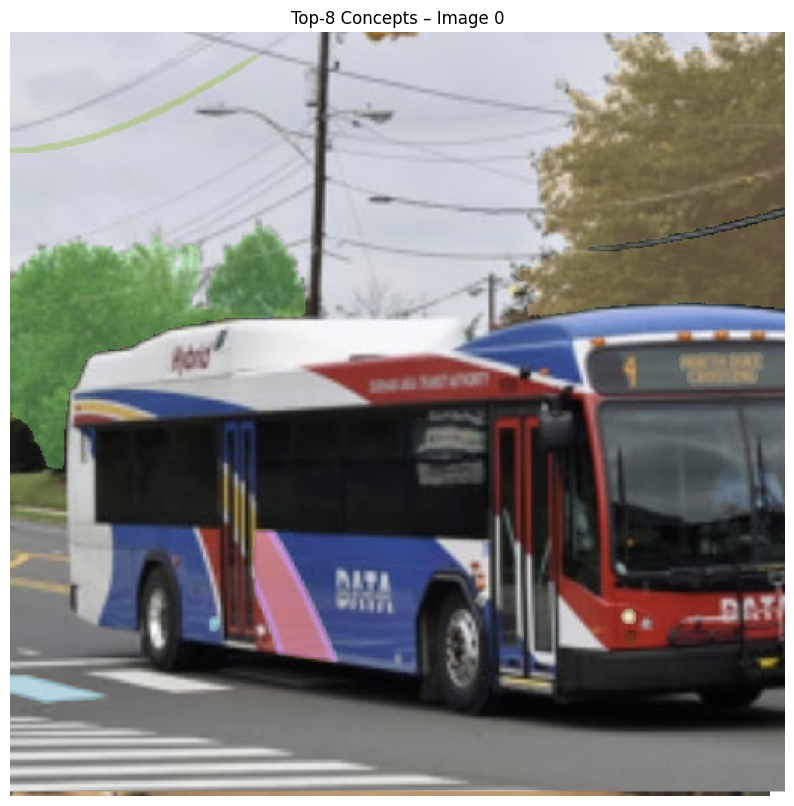

[Image 1] Top-8 concepts : [82, 12, 7, 62, 84, 93, 21, 9]


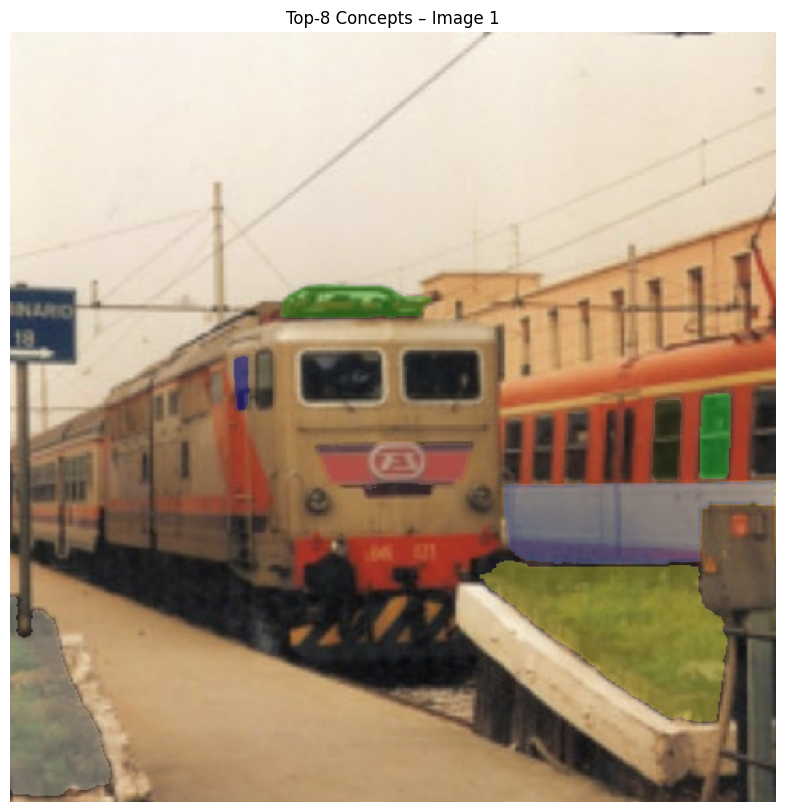

[Image 2] Top-8 concepts : [11, 2, 25, 4, 3, 15, 1, 23]


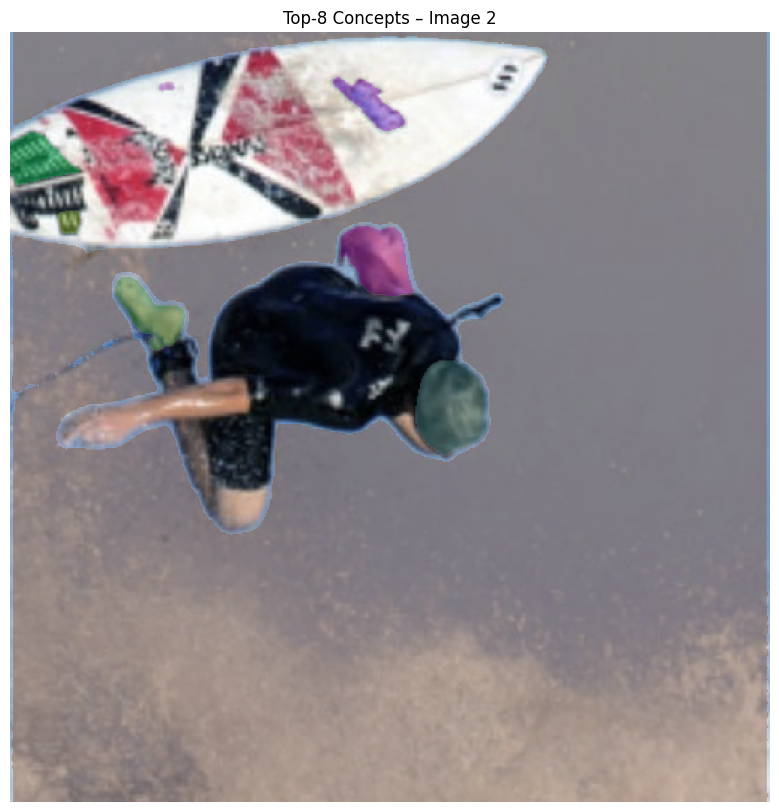

[Image 3] Top-8 concepts : [31, 24, 22, 14, 17, 19, 30, 8]


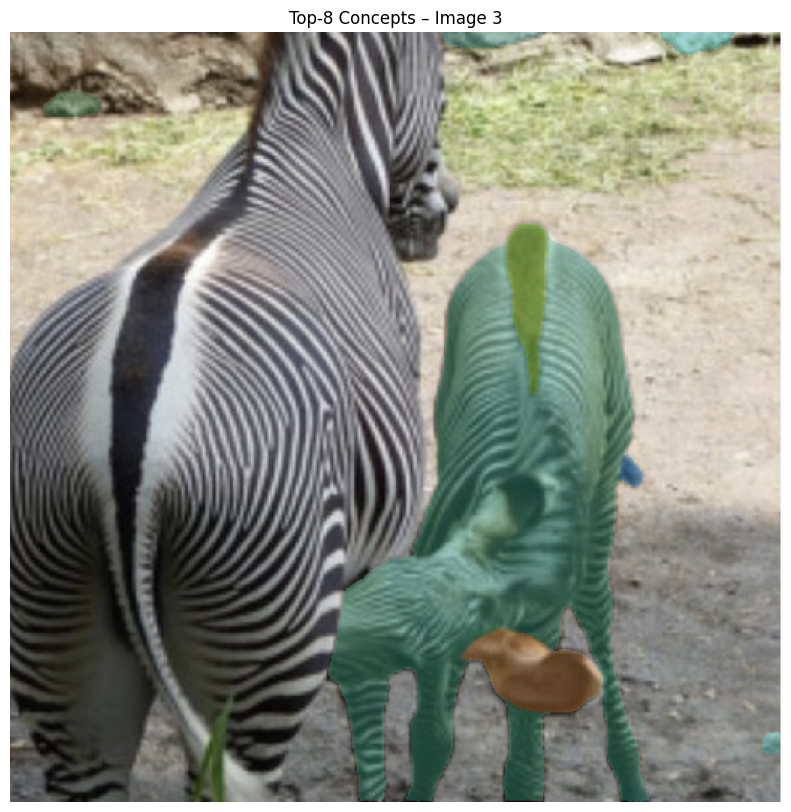

In [ ]:
top_k_concepts = 8  # number of concept to sompute per image

for img_idx in range(len(images)):
    # Retrieve the Shapley values ​​for this image
    shap_values = all_shapley_values[img_idx]

    # Indices of top k concepts
    _, topk_indices = torch.topk(shap_values, top_k_concepts)
    topk_indices = topk_indices.tolist()

    print(f"[Image {img_idx}] Top-{top_k_concepts} concepts :", topk_indices)

    # Get corresponding masks
    masks_shapley = [masks[img_idx][i] for i in topk_indices]  # list of dictionaries (with key 'segmentation')

    # Plot masks on top of images
    plt.figure(figsize=(10, 10))
    plt.imshow(images[img_idx])
    show_anns(masks_shapley)
    plt.axis('off')
    plt.title(f"Top-{top_k_concepts} Concepts – Image {img_idx}")
    plt.show()


In [ ]:
def show_masked_pixels(image, masks_subset: list, title:str="Masques SHAP (top-k)"):
    """
    Displays the image showing only the pixels activated by the selected masks.

    Args:
        image (np.ndarray): Image RGB  (H x W x 3)
        masks_subset (list of np.ndarray): Masques binaires (H x W), booléens ou 0/1
        title (str): Titre du plot
    """
    if not masks_subset:
        print("Aucun masque à afficher.")
        return

    # Ensure all mask to be boolean of same size
    masks_subset = [np.array(mask, dtype=bool) for mask in masks_subset]

    # Merge masks
    combined_mask = np.zeros_like(masks_subset[0], dtype=bool)
    for mask in masks_subset:
        combined_mask |= mask

    # Apply mask to the image
    masked_image = image.copy()
    masked_image[~combined_mask] = 0  # Background to black

    plt.imshow(masked_image)
    plt.title(title)
    plt.axis("off")
    plt.show()


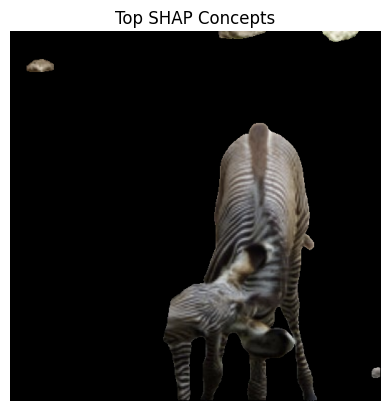

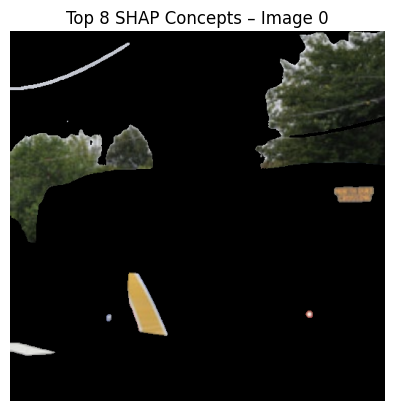

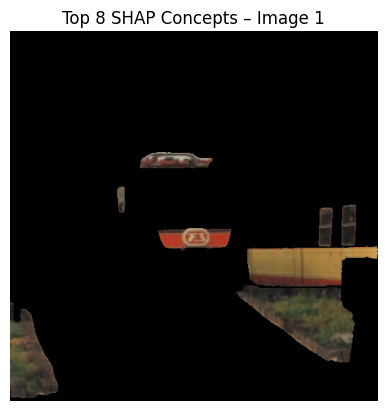

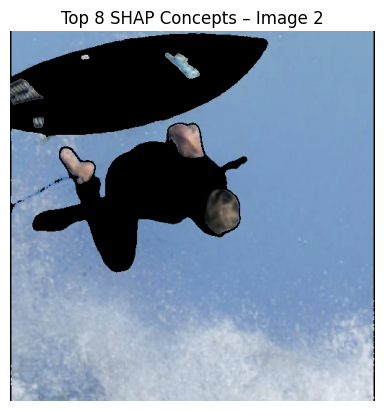

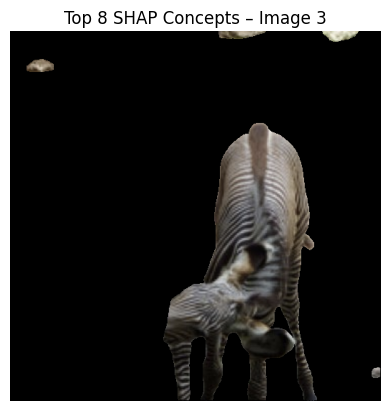

In [ ]:
binary_masks = [m['segmentation'] for m in masks_shapley]
show_masked_pixels(image, binary_masks, title="Top SHAP Concepts")

for img_idx in range(len(images)):
    shap_values = all_shapley_values[img_idx]
    image = images[img_idx]

    # Retrive top-k concepts
    _, topk_indices = torch.topk(shap_values, top_k_concepts)
    topk_indices = topk_indices.tolist()

    masks_shapley = [masks[img_idx][i] for i in topk_indices]
    binary_masks = [m['segmentation'] for m in masks_shapley]

    # Plot
    show_masked_pixels(image, binary_masks, title=f"Top {top_k_concepts} SHAP Concepts – Image {img_idx}")


**Evaluation metric**

Insertion and Deletion scheme

In [ ]:
from sklearn.metrics import auc
import numpy as np

''' #--- Step 1: Order the concepts by SHAP importance ---
shap_np = shapley_values.detach().cpu().numpy()
sorted_idx = np.argsort(-shap_np) # from most to least important
sorted_masks = [concepts[i] for i in sorted_idx] # concepts = list of HxW bitmasks
 '''

# --- Step 2: Insert/Deletion Function ---
def apply_concepts(img : np.array, masks: list, model=model, normalize, mode='insertion', image_class=None):
    """
    img: image originale (numpy RGB)
    model :target model (resnet)
    normalize : apply imagenet normalisation
    masks: liste de masques binaires (H x W), ordonnés par importance
    """
    H, W, C = img.shape
    base = np.zeros_like(img) if mode == 'insertion' else img.copy()
    step_preds = []

    # create cumulative masks: logical accumulation of top-k masks
    cumulative_masks = []
    current_mask = np.zeros((H, W), dtype=bool)
    for mask in masks:
        current_mask = np.logical_or(current_mask, mask)
        cumulative_masks.append(current_mask.copy())

    for cum_mask in cumulative_masks:
        mask = cum_mask[:, :, None]  # shape (H, W, 1)
        if mode == 'insertion':
            applied = np.where(mask, img, 0)
        elif mode == 'deletion':
            applied = np.where(mask, 0, img)

        with torch.no_grad():
            inp = torch.from_numpy(applied).permute(2, 0, 1).float() / 255.
            inp = normalize(inp).unsqueeze(0).to("cuda")
            pred = model(inp)
            if image_class is None:
                image_class = pred.argmax().item()
            proba = torch.softmax(pred, dim=1)[0, image_class].item()

        step_preds.append(proba)

    return step_preds


# --- Étape 3 : AUC ---
def compute_auc(step_preds):
    x = np.linspace(0, 1, len(step_preds))
    return auc(x, step_preds)


''' # --- Step 4  : Compute scores ---
# Choose the predicted class
with torch.no_grad():
    inp = torch.from_numpy(image).permute(2, 0, 1).float() / 255.
    inp = normalize(inp).unsqueeze(0).to("cuda")
    image_class = target_model(inp).argmax().item()

    print("Image class:", image_class)
    # ou utliser predicted_idx '''


' # --- Étape 4 : Calcule les scores ---\n# Choisir la classe prédite initialement\nwith torch.no_grad():\n    inp = torch.from_numpy(image).permute(2, 0, 1).float() / 255.\n    inp = normalize(inp).unsqueeze(0).to("cuda")\n    image_class = target_model(inp).argmax().item()\n\n    print("Image class:", image_class)\n    # ou utliser predicted_idx '

In [ ]:
def compute_auc_normalized(step_preds, original_proba):
    preds = np.array(step_preds)
    preds[preds >= original_proba] = original_proba
    preds = preds / original_proba
    x = np.linspace(0, 100, len(preds))
    return auc(x, preds)

In [ ]:
insertion_aucs = []
deletion_aucs = []

for img_idx, (image, image_class) in enumerate(zip(images, predicted_indices)):
    # Valeurs de Shapley pour l'image courante
    shapley_values = all_shapley_values[img_idx]
    shap_np = shapley_values.detach().cpu().numpy()

    # Récupérer les masques binaires HxW pour cette image depuis masks
    concepts = [m["segmentation"] for m in masks[img_idx]]  # masks = liste de listes de dicts

    # Trier les concepts du + important au -
    sorted_idx = np.argsort(-shap_np)
    sorted_masks = [concepts[i] for i in sorted_idx]

    # Appliquer insertion / suppression
    insertion_scores = apply_concepts(image, sorted_masks, target_model, normalize, mode='insertion', image_class=image_class)
    deletion_scores = apply_concepts(image, sorted_masks, target_model, normalize, mode='deletion', image_class=image_class)

    # Prédiction originale
    with torch.no_grad():
        inp = torch.from_numpy(image).permute(2, 0, 1).float() / 255.
        inp = normalize(inp).unsqueeze(0).to("cuda")
        original_proba = torch.softmax(target_model(inp), dim=1)[0, image_class].item()

    # AUCs
    insertion_auc = compute_auc_normalized(insertion_scores, original_proba)
    deletion_auc = compute_auc_normalized(deletion_scores, original_proba)

    insertion_aucs.append(insertion_auc)
    deletion_aucs.append(deletion_auc)

    print(f"[Image {img_idx}] Insertion AUC: {insertion_auc:.4f} | Deletion AUC: {deletion_auc:.4f}")


[Image 0] Insertion AUC: 72.8161 | Deletion AUC: 23.3864
[Image 1] Insertion AUC: 77.6341 | Deletion AUC: 45.2705
[Image 2] Insertion AUC: 51.1952 | Deletion AUC: 27.3308
[Image 3] Insertion AUC: 77.6467 | Deletion AUC: 30.4094
